<b>LAB 7</b><br>
As part of a cellular biology research initiative, you are tasked with analyzing the cellular structure of bananas to assess nutrient distribution. Given high-resolution microscopic images, it has been observed that conventional thresholding techniques inadequately separate individual cells due to overlapping regions and intensity variations within the images. To achieve precise segmentation, apply the watershed segmentation method.<br>
Task Requirements:<br>

1. Objective: Implement the watershed segmentation algorithm to accurately delineate individual banana cells.<br>
2. Procedures:<br>
○ Preprocessing: Propose and apply suitable preprocessing techniques to enhance image contrast and suppress background noise.<br>
○ Marker Identification: Define markers to differentiate foreground regions (cells) from background areas, ensuring accurate initialization for the watershed algorithm.<br>
○ Segmentation: Use the watershed algorithm to segment the cells, effectively separating contiguous cell boundaries.<br>

<b>Cellular Segmentation in Bananas Using Watershed Algorithm</b><br>
This lab task aims to accurately segment individual cells in high-resolution microscopic images of banana tissue. The goal is to highlight cells themselves, not the spaces between them, which requires careful preprocessing and marker definition for the watershed algorithm.

<b>STEP 1: LOADING IMAGE

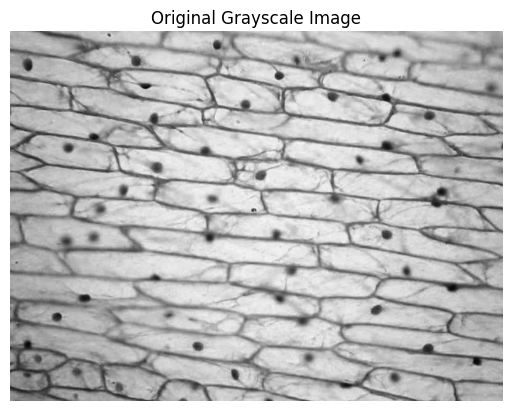

In [34]:
# Import necessary libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the high-resolution image
image = cv.imread('bananaCell.jpg')

gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# Display the original grayscale image
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')
plt.show()


We start by importing essential libraries and reading the banana cell image. Converting to grayscale simplifies the image, reducing it to one intensity channel, which is beneficial for binary segmentation.

<b>STEP 2: PRE-PROCESSING

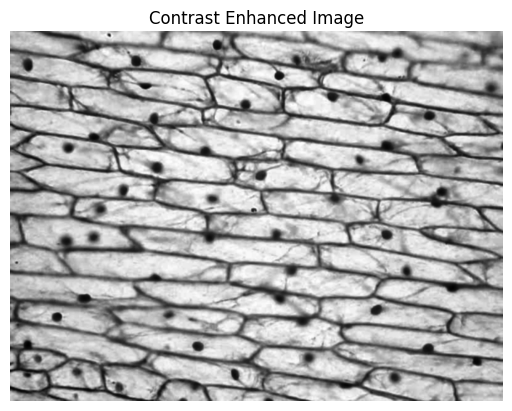

In [53]:
# Apply Gaussian Blur to reduce noise
blurred = cv.GaussianBlur(gray, (3, 3), 0)

# Use adaptive histogram equalization for contrast enhancement
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(blurred)

# Display the enhanced image
plt.imshow(enhanced, cmap='gray')
plt.title("Contrast Enhanced Image")
plt.axis('off')
plt.show()


Objective: Improve cell contrast against the background to make segmentation more accurate.<br>

Gaussian Blur smoothens out minor noise that could interfere with segmentation.<br>
CLAHE (Contrast Limited Adaptive Histogram Equalization) enhances the contrast of cell regions. Unlike simple histogram equalization, CLAHE adjusts contrast locally, making cells more distinguishable without over-enhancing noise.<br>

Enhanced contrast allows cells to stand out more, improving the effectiveness of the following steps.

<b>STEP 3: INVERTED BINARY THRESHOLDING TO HIGHLIGHT CELLS</b>

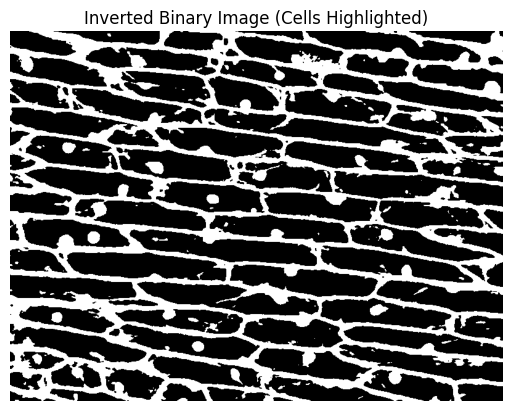

In [54]:
# Apply Otsu's thresholding with inversion to highlight cells
_, binary = cv.threshold(enhanced, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# Display the binary image with cells highlighted
plt.imshow(binary, cmap='gray')
plt.title("Inverted Binary Image (Cells Highlighted)")
plt.axis('off')
plt.show()


Explanation: Thresholding separates cells (foreground) from the background by converting the image to a binary format where cells are white, and the background is black. Inverting the binary output ensures cells are highlighted.<br>

Cells are emphasized as the foreground, making it easier to distinguish their boundaries in the segmentation stage.<br>

This inversion is crucial as it allows the watershed algorithm to treat cells as the main objects of interest.<br>

<br>STEP 4: DISTANCE TRANSFORM

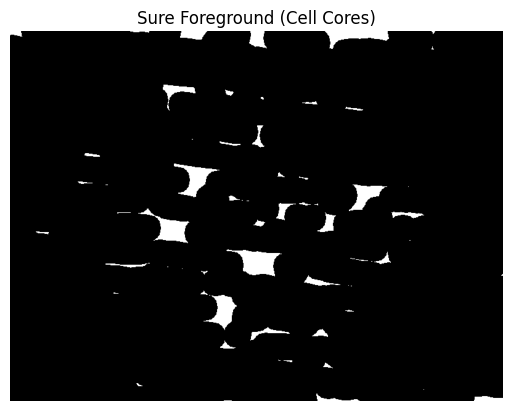

In [47]:
# Apply distance transform
dist_transform = cv.distanceTransform(binary, cv.DIST_L2, 5)

# Threshold the distance transform to get core regions of cells
_, sure_fg = cv.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Display sure foreground (cell cores)
plt.imshow(sure_fg, cmap='gray')
plt.title("Sure Foreground (Cell Cores)")
plt.axis('off')
plt.show()


Objective: Use distance transform and thresholding to identify the core regions of cells, which serve as markers.<br>

The distance transform highlights the "core" of each cell based on pixel distance from the background. By thresholding these regions, we create "sure" foreground markers, which represent cell centers with high certainty.<br>

This step enhances separation of closely positioned cells by emphasizing central regions, facilitating accurate cell identification in the next steps.

<b>STEP 5: REFINE BACKGROUND AND UNKNOWN REGIONS

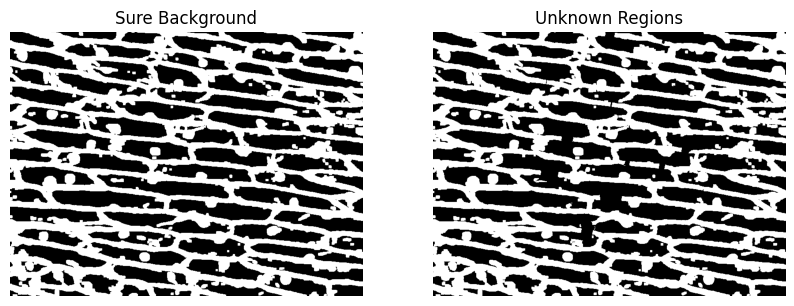

In [55]:
# Use morphological operations to define the sure background
kernel = np.ones((3, 3), np.uint8)
sure_bg = cv.dilate(binary, kernel, iterations=2)

# Define unknown regions by subtracting sure foreground from sure background
unknown = cv.subtract(sure_bg, sure_fg)

# Display sure background and unknown regions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sure_bg, cmap='gray')
plt.title("Sure Background")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(unknown, cmap='gray')
plt.title("Unknown Regions")
plt.axis('off')
plt.show()


Objective: Refine the sure background and define "unknown" regions for the watershed.<br>

Justification:<br>
Morphological Dilation expands the binary regions, creating sure background areas around cells.<br>
The unknown region (difference between sure background and foreground) is essential for the watershed algorithm, helping it differentiate between closely packed cells.<br>

Separating known cell areas, sure background, and unknown regions creates clear markers for accurate boundary identification.

<b>STEP 6: APPLYING WATERSHED ALGORITHM

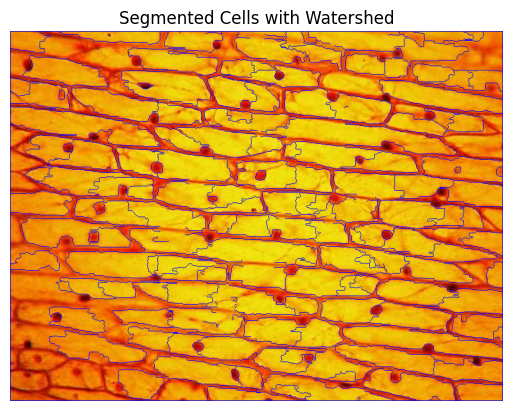

In [56]:
# Label markers for watershed
markers = cv.connectedComponents(sure_fg)[1]

# Increment markers to distinguish background
markers = markers + 1

# Mark unknown regions as zero for watershed
markers[unknown == 255] = 0

# Apply the watershed algorithm
markers = cv.watershed(image, markers)

# Draw boundaries around segmented cells
image[markers == -1] = [255, 0, 0]  # Red boundary around cells

# Display the final segmented result
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.title("Segmented Cells with Watershed")
plt.axis('off')
plt.show()


Objective: Segment cells by applying the watershed algorithm to the image using the defined markers.<br>

Justification:<br>
Connected Components: Used to label each cell core, which acts as the foreground marker for watershed.<br>
Marker Adjustment: Background is incremented to a different marker value, while unknown regions are set to zero. These markers guide the watershed algorithm in separating cells accurately.<br>

Inference: The watershed algorithm uses the markers to segment cells effectively, producing boundaries that distinguish individual cells. This approach leverages marker-based segmentation to yield a precise, cell-focused output.

Inverted Thresholding: This step ensures the cells are highlighted as the foreground, making it easier for the watershed algorithm to identify cell boundaries instead of the spaces between them.<br>

Distance Transform and Morphology: By identifying cell cores and using morphological operations, we improve the separation of cells, especially where they are closely positioned or overlapping.<br>

Refined Markers for Watershed: The accurate labeling of foreground, background, and unknown regions allows the watershed algorithm to focus on cell boundaries, resulting in cleaner segmentation.<br>